In [1]:
import os, sys
from pathlib import Path

BASE_DIR = Path(Path.home(), "workspace", "services", "credit_model")
DATA_DIR = Path(Path.home(), "workspace", "data")
if BASE_DIR not in sys.path:
    sys.path.insert(0, f"{BASE_DIR}")

In [2]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path

from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
import os
%load_ext autoreload
%autoreload 2

In [3]:
file = Path(DATA_DIR, "credit_score_dict.pickle") 
input_file = open(file, "rb")
cs = pickle.load(input_file)

#Model Contariner Parameters
y_true = np.array(cs["y_test"])
y_pred = np.array(cs["y_pred"])
y_train = np.array(cs["y_train"])

x_train = cs["X_train"]
x_test = cs["X_test"]
model_name = "credit_scoring"
model_type = "classification"
y_prob = cs["y_prob"]

p_grp = {'SEX': [1], 'MARRIAGE':[1]}
up_grp = {'SEX': [2], 'MARRIAGE':[2]}

C:\Users\USER\.conda\envs\ai310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\USER\.conda\envs\ai310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\USER\.conda\envs\ai310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid result

## Data Exploration

In [4]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0],x_train.shape[1]))
x_train.head()

No of rows: 22500 
No. of columns: 23


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,50000.0,1,2,2,28,0,0,0,0,0,...,25454.0,26030.0,26609.0,27662.0,1500.0,1500.0,1000.0,1000.0,1500.0,1100.0
1,210000.0,2,2,1,44,0,0,0,0,0,...,42889.0,42936.0,44936.0,47166.0,4534.0,3000.0,1000.0,2000.0,2230.0,1026.0
2,80000.0,2,1,1,29,-1,-1,-1,-1,0,...,1872.0,746.0,746.0,4424.0,358.0,1872.0,746.0,0.0,4424.0,0.0
3,30000.0,2,3,1,43,0,0,0,0,0,...,15459.0,15366.0,15680.0,15000.0,1481.0,1400.0,307.0,314.0,300.0,1770.0
4,200000.0,2,1,2,28,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,510.0


counts = pd.Series(y_train).value_counts()
print("count of neg class: {} \ncount of pos class: {}".format(counts[0],counts[1]))

In [5]:
x_train.describe().astype(int)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500,...,22500,22500,22500,22500,22500,22500,22500,22500,22500,22500
mean,168028,1,1,1,35,0,0,0,0,0,...,47135,43407,40400,39077,5634,6009,5327,4831,4903,5267
std,130059,0,0,0,9,1,1,1,1,1,...,69918,64817,61373,60211,16336,24712,18575,16145,15542,17991
min,10000,1,0,0,21,-2,-2,-2,-2,-2,...,-157264,-170000,-53007,-339603,0,0,0,0,0,0
25%,50000,1,1,1,28,-1,-1,-1,-1,-1,...,2616,2295,1700,1235,988,800,390,291,237,115
50%,140000,2,2,2,34,0,0,0,0,0,...,20009,19060,17966,17046,2121,2005,1800,1500,1500,1500
75%,240000,2,2,2,41,0,0,0,0,0,...,60360,54526,50149,49112,5009,5000,4500,4000,4078,4007
max,1000000,2,6,3,75,8,7,8,8,8,...,1664089,891586,927171,961664,873552,1684259,896040,621000,426529,528666


## Building Model 

In [6]:
#Upsampling
categorical_features = [i for i, col in enumerate(x_train.columns) if str(x_train[col].dtype).startswith('int')]
smote = SMOTENC(random_state=0, categorical_features=categorical_features)
X_upsml, y_upsml = smote.fit_resample(x_train, y_train)

#Scaling
scaling = StandardScaler()
X_upsml_scld = scaling.fit_transform(X_upsml)

#Model fitting
log_reg = LogisticRegression(C=0.1,random_state=0,  max_iter=4000)
log_reg.fit(X_upsml_scld, y_upsml)

LogisticRegression(C=0.1, max_iter=4000, random_state=0)

In [7]:
x_test_scaled = scaling.transform(x_test)
test_preds = log_reg.predict(x_test_scaled)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,test_preds),3)))

Balanced Accuracy: 0.665


In [8]:
#Using finetuned Threshold
best_th = 0.43

test_probs = log_reg.predict_proba(x_test_scaled)[:, 1] 
test_preds = np.where(test_probs > best_th, 1, 0)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,test_preds),3)))

Balanced Accuracy: 0.685


# 2. Fairness & Transparency Diagnosis


## Import Veritas Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. CreditScoring is showcased in this notebook.

In [9]:
from util.feat.model.modelwrapper import ModelWrapper
from util.feat.model.model_container import ModelContainer
from util.feat.usecases.credit_scoring import CreditScoring

## Create model object using Model Wrapper

In [10]:
class LRwrapper(ModelWrapper):

    def __init__(self, model_obj, classes=[0, 1]):
        self.model_obj = model_obj
        self.classes_ = classes
       

    def fit(self, X, y):
    
        #Upsampling
        categorical_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'int8']
        smote = SMOTENC(random_state=0, categorical_features=categorical_features)
        X, y = smote.fit_resample(X, y)

        #Scaling
        scaling = StandardScaler()
        X = scaling.fit_transform(X)

   
        self.model_obj.fit(X, y)
  
    
    def predict(self, x_test, best_th = 0.43):
        
        test_probs = self.model_obj.predict_proba(x_test.values)[:, 1] 
        
        #Using finetuned Threshold
        test_preds = np.where(test_probs > best_th, 1, 0)
        return test_preds
    
    
    def predict_proba(self, x_test):
        
        return self.model_obj.predict_proba(x_test.values)

In [11]:
log_reg_untrained = LogisticRegression(C=0.1)
model_obj = LRwrapper(log_reg_untrained)

In [12]:
model_obj.fit(x_train, y_train)

In [13]:
#Create Model Container 
container = ModelContainer(y_true, p_grp, model_type, model_name, y_pred, y_prob, y_train, x_train=x_train,
                           x_test=x_test, model_object=model_obj, up_grp=up_grp)


In [14]:
#Create Use Case Object
cre_sco_obj= CreditScoring(model_params = [container], fair_threshold = 80, fair_concern = "eligible", \
                           fair_priority = "benefit", fair_impact = "normal", perf_metric_name="accuracy", \
                           tran_row_num = [20,40], tran_max_sample = 1000, tran_pdp_feature = ['LIMIT_BAL'], tran_max_display = 10)

In [15]:
cre_sco_obj.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                          77.880%
	neg_label                                                          22.120%


Performance Metrics
	Selection Rate                                             0.781 +/- 0.010
	Accuracy                                                   0.784 +/- 0.009
	Balanced Accuracy                                          0.685 +/- 0.013
	Recall                                                     0.863 +/- 0.008
	Precision                                                  0.860 +/- 0.009
	F1 Score                                                   0.861 +/- 0.007
	True Negative Rate                                         0.506 +/- 0.025
	False Negative Rate                                        0.137 +/- 0.008
	Negative Predictive Value                                  0.512 +/- 0.023
	ROC AUC Score                                              0.726 +/- 0.016
	Log-loss                                     

In [16]:
cre_sco_obj.evaluate(visualize = True, output = True) 

In [17]:
cre_sco_obj.tradeoff()

Tradeoff:   0%|          


-------------------------------- 1. SEX --------------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.446
		Best balanced_acc*                                0.674
	 Separated Thresholds
		Privileged Threshold                              0.431
		Unprivileged Threshold                            0.422
		Best balanced_acc*                                0.688
	 Separated Thresholds under Neutral Fairness (0.001)
		Privileged Threshold                              0.413
		Unprivileged Threshold                            0.443
		Best balanced_acc*                                0.684
		*estimated by approximation, subject to the resolution of mesh grid

----------------------------- 2. MARRIAGE  -----------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.446
		Best balanced_acc*                                0.674
	 Separated

In [18]:
cre_sco_obj.feature_importance()

Feature importance:   0%|          




--------------------------------------------------1: Fairness on Sex--------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |accuracy                 |equal_opportunity        |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|SEX                           |-0.012                   |0.052                    |fair to fair (+)    |Examine Further   |
----------------------------------------------------------------------------------------------------------------------------
|MARRIAGE                      |-0.014                   |0.047                    |fair to fair (+)    |Examine Further   |
-------------------------------------------------------------------------------------------------------------------------

Correlation analysis :   0%|          

Permutation explainer: 1003it [00:14, 27.75it/s]                                                                       

Correlation matrix skipped


Root cause analysis:   0%|          



                              Top 10 contributors towards bias for class '1'      
                         Measured by SHAP-based Demographic Parity on 1002 samples




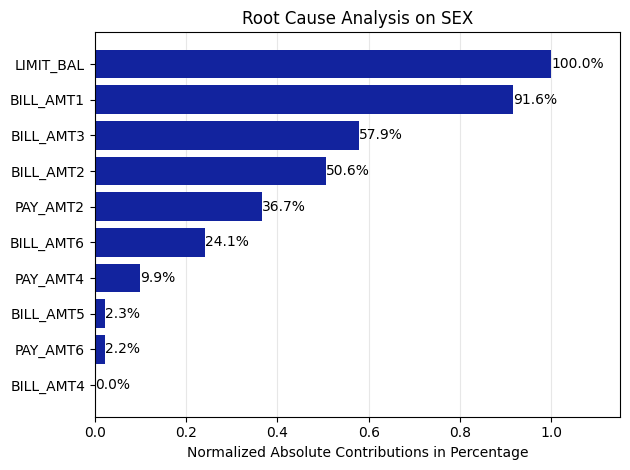

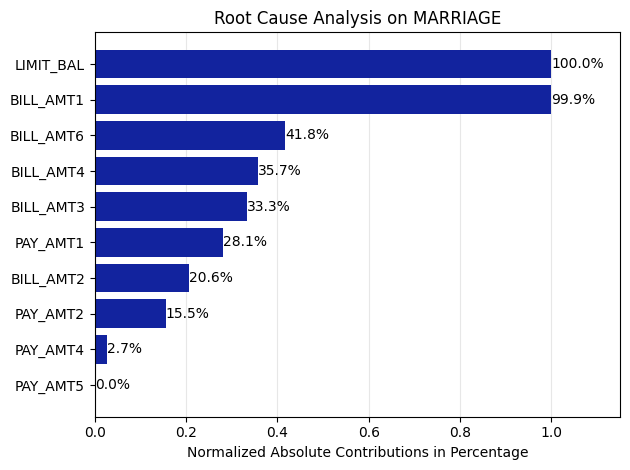

In [29]:
cre_sco_obj.rootcause(p_var=['SEX', 'MARRIAGE'])

In [30]:
mitigated = cre_sco_obj.mitigate(p_var=['SEX', 'MARRIAGE'], method=['reweigh', 'correlate', 'threshold'])

Bias mitigation :   0%|          


*Effective input for p_var = ['SEX', 'MARRIAGE']

                                Threshold tuning                                

--------------------------------------------------------------------------------
|Protected variable            |Privileged             |Unprivileged           |
--------------------------------------------------------------------------------
|SEX                           |0.413                  |0.443                  |
--------------------------------------------------------------------------------
|MARRIAGE                      |0.414                  |0.449                  |
--------------------------------------------------------------------------------


                                   Reweighing                                   

--------------------------------------------------------------------------------
|SEX, MARRIAGE                 |Label                  |Weight                 |
------------------------------------------------------

In [21]:
# y_pred can be used to reinitialise the model container and rerun fairness assessment
y_pred_sex_mitigated = mitigated['threshold'][0]
y_pred_marriage_mitigated = mitigated['threshold'][1]

In [22]:
sample_weights_mitigated = mitigated['reweigh'][0]

In [23]:
indices = np.random.choice(x_test.index, size=50, replace=False)
x_test_sample = x_test.loc[indices].reset_index(drop=True)
y_true_sample = y_true[indices]
group_weights = mitigated['reweigh'][1]

In [24]:
transform_mitigated = cre_sco_obj.mitigate(method=['reweigh'], rw_weights=group_weights, \
                                           transform_x=x_test_sample, transform_y=y_true_sample)

Bias mitigation :   0%|          


*Effective input for p_var = ['SEX', 'MARRIAGE']

                                   Reweighing                                   

Calculating sample_weights for transform_x based on provided rw_weights,
transform_y.



In [25]:
transform_mitigated['reweigh']

array([1.0029314 , 1.0029314 , 0.99894996, 1.10287129, 0.97419092,
       0.98981414, 0.99894996, 0.99894996, 0.99894996, 1.04583249,
       0.97419092, 0.97419092, 0.99894996, 0.97419092, 1.00371461,
       0.97419092, 1.00371461, 1.0029314 , 1.0029314 , 0.97419092,
       0.98981414, 0.99894996, 1.04583249, 0.99894996, 1.04583249,
       1.10287129, 1.04583249, 1.0029314 , 0.99894996, 1.0029314 ,
       1.04583249, 1.10287129, 1.00371461, 0.97419092, 0.97419092,
       0.97419092, 1.04583249, 1.04583249, 1.04583249, 0.99894996,
       1.0029314 , 1.00371461, 1.0029314 , 0.97419092, 0.99894996,
       1.04583249, 0.97419092, 1.0029314 , 0.99894996, 0.97419092])

## Starting Transparency Diagnosis

Running transparency for model 1        done      


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


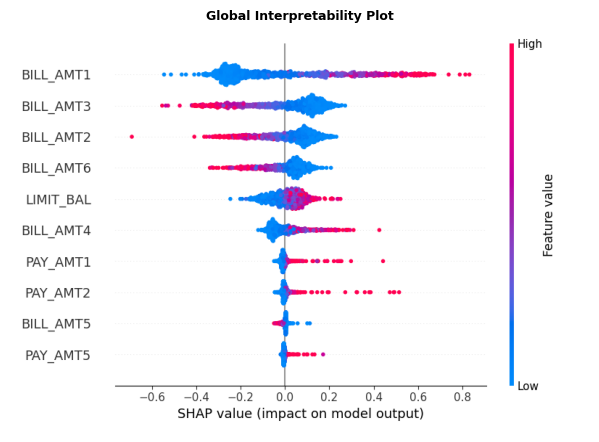

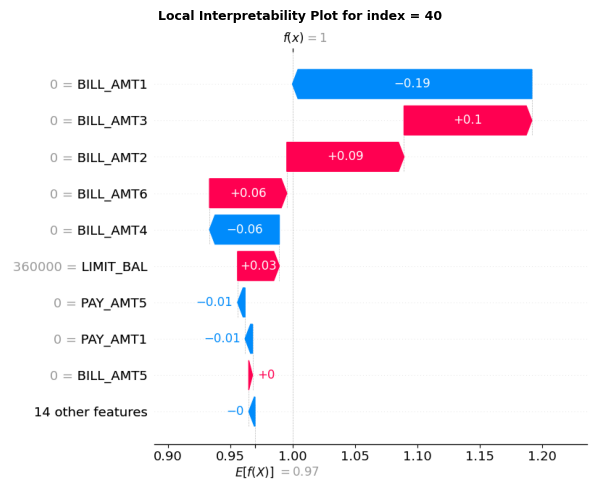

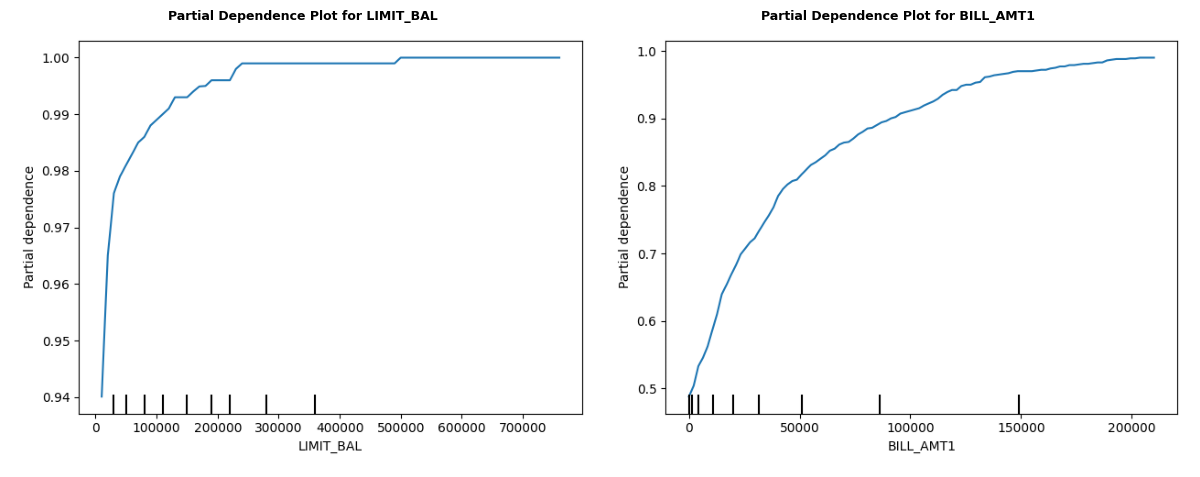

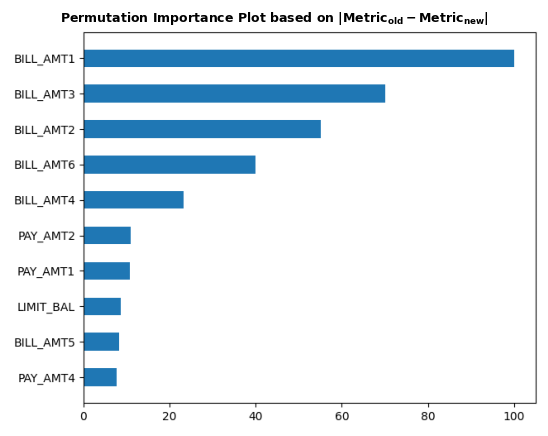

In [26]:
#run the entire transparency analysis
cre_sco_obj.explain()

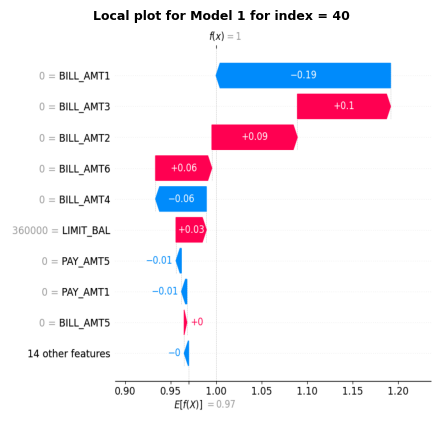

In [27]:
cre_sco_obj.explain(local_row_num = 40, model_num = 1)

In [28]:
cre_sco_obj.compile()

Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            done      
     performance dynamics               done      
     individual fairness                done      
Running tradeoff                        done      
Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               skipped   
Running transparency for model 1        done      
Generating model artifact               done
Saved model artifact to model_artifact_credit_scoring_20231112_1551.json
